In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint
import sklearn
import warnings, random, pickle, sys
warnings.filterwarnings("ignore")
sys.path.append('../src/')
from utils import *

In [2]:
# read data
interaction = pd.read_csv("../data/customer_interactions.csv")
product = pd.read_csv("../data/product_details.csv", sep=";")
purchase = pd.read_csv("../data/purchase_history.csv", sep=";")

# drop unnecessary columns
for col in product.columns:
  if col.startswith("Unnamed"):
    product.drop(columns=col, inplace=True)

for col in purchase.columns:
  if col.startswith("Unnamed"):
    purchase.drop(columns=col, inplace=True)

# checking
display(interaction)
display(interaction.info())

display(product)
display(product.info())

display(purchase)
display(purchase.info())

,customer_id,page_views,time_spent
0,1,25,120
1,2,20,90
2,3,30,150
3,4,15,80
4,5,22,110


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_id  5 non-null      int64
 1   page_views   5 non-null      int64
 2   time_spent   5 non-null      int64
dtypes: int64(3)
memory usage: 248.0 bytes


None

,product_id,category,price,ratings
0,101,Electronics,500,4.5
1,102,Clothing,50,3.8
2,103,Home & Kitchen,200,4.2
3,104,Beauty,30,4.0
4,105,Electronics,800,4.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  5 non-null      int64  
 1   category    5 non-null      object 
 2   price       5 non-null      int64  
 3   ratings     5 non-null      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 288.0+ bytes


None

,customer_id,product_id,purchase_date
0,1,101,2023-01-01
1,1,105,2023-01-05
2,2,102,2023-01-02
3,3,103,2023-01-03
4,4,104,2023-01-04
5,5,101,2023-01-05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    6 non-null      int64 
 1   product_id     6 non-null      int64 
 2   purchase_date  6 non-null      object
dtypes: int64(2), object(1)
memory usage: 272.0+ bytes


None

In [3]:
merged_df = pd.merge(
  interaction, 
  purchase, 
  left_on="customer_id", 
  right_on="customer_id", 
  how="outer"
).merge(
  product, 
  left_on="product_id", 
  right_on="product_id", 
  how="outer"
).sort_values(
  ["page_views"]
).reset_index(drop=True)
merged_df

,customer_id,page_views,time_spent,product_id,purchase_date,category,price,ratings
0,4,15,80,104,2023-01-04,Beauty,30,4.0
1,2,20,90,102,2023-01-02,Clothing,50,3.8
2,5,22,110,101,2023-01-05,Electronics,500,4.5
3,1,25,120,101,2023-01-01,Electronics,500,4.5
4,1,25,120,105,2023-01-05,Electronics,800,4.8
5,3,30,150,103,2023-01-03,Home & Kitchen,200,4.2


In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customer_id    6 non-null      int64  
 1   page_views     6 non-null      int64  
 2   time_spent     6 non-null      int64  
 3   product_id     6 non-null      int64  
 4   purchase_date  6 non-null      object 
 5   category       6 non-null      object 
 6   price          6 non-null      int64  
 7   ratings        6 non-null      float64
dtypes: float64(1), int64(5), object(2)
memory usage: 512.0+ bytes


In [5]:
merged_df.groupby("category").mean()#.corr()#.describe()

,customer_id,page_views,time_spent,product_id,price,ratings
category,,,,,,
Beauty,4.000000,15.0,80.000000,104.000000,30.0,4.0
Clothing,2.000000,20.0,90.000000,102.000000,50.0,3.8
Electronics,2.333333,24.0,116.666667,102.333333,600.0,4.6
Home & Kitchen,3.000000,30.0,150.000000,103.000000,200.0,4.2


In [6]:
merged_df.drop(columns=["customer_id", "product_id"]).corr().style.background_gradient()

,page_views,time_spent,price,ratings
page_views,1.000000,0.978787,0.444448,0.466486
time_spent,0.978787,1.000000,0.414060,0.480461
price,0.444448,0.414060,1.000000,0.973779
ratings,0.466486,0.480461,0.973779,1.000000


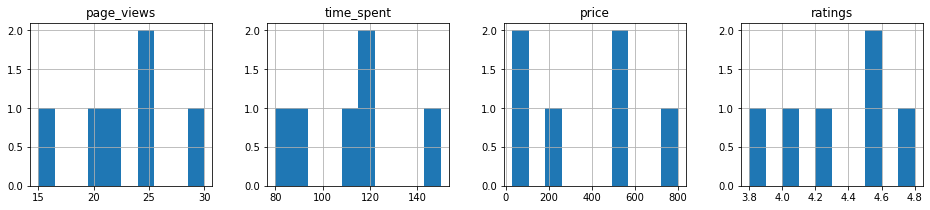

In [7]:
num_cols = [c for c in \
            merged_df.select_dtypes("int64").columns.append(merged_df.select_dtypes("float64").columns) \
            if "id" not in c]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
for i, col in enumerate(num_cols):
  merged_df[[col]].hist(ax=axes[i])

# Notes

- Metric:  
  - Mean Reciprocal Rank (MRR) -> since limited data (category/product item), suitable for limited data like some new approach to use
  - MAP -> general [optional/additional]
  - Precision@5 -> general [optional/additional]

# Upsampling with Synthetic Data

- Upsampling(Generate Synthetic) product: add 3-5 item with +- 10%-30% price and ratings per category
- Upsampling(Generate Synthetic) user features: add 3-5 behaviour(time spent & page views) +- 10%-30% time spent & page views per category

In [8]:
le_cat = LabelEncoder()
le_pd = LabelEncoder()
le_cat.fit(merged_df["category"])
le_pd.fit(merged_df["purchase_date"])

LabelEncoder()

In [9]:
def add_synthetic_data(df: pd.DataFrame, ll: float = 0.8, ul: float = 1.2) -> pd.DataFrame:
    """
    Adds synthetic data to a DataFrame by replicating rows, generating random percentages,
    and scaling values based on specified limits.

    Args:
        df: The input DataFrame.
        ll: The lower limit for the uniform random distribution (default: 0.8).
        ul: The upper limit for the uniform random distribution (default: 1.2).

    Returns:
        A new DataFrame with synthetic data added.

    Raises:
        ValueError: If the input DataFrame is empty or if any column contains non-numeric data.
    """

    if df.empty:
        raise ValueError("Input DataFrame cannot be empty.")

    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' contains non-numeric data.")

    # Replicate each row
    df_replicated = df.loc[df.index.repeat(1)]

    # Generate random percentage for each row
    random_percentages = [np.random.uniform(low=ll, high=ul)]

    # Calculate new values for each column
    for col in df_replicated.columns:
        df_replicated[col] *= random_percentages

    # Adjust "ratings" values max at 5
    df_replicated["ratings"] = df_replicated["ratings"].apply(lambda x: 5.00 if x>5 else round(x,2) )

    # Adjust "ratings" values max at 4
    df_replicated["purchase_date"] = df_replicated["purchase_date"].apply(lambda x: 4 if x>4 else round(x) )
    df_replicated["category"] = df_replicated["category"].apply(lambda x: 3 if x>3 else round(x) )

    # Shift "product_id" values by 200 (a constant)
    df_replicated["product_id"] += 200
    
    # Round numeric columns
    for col in ["customer_id", "product_id", "page_views", "time_spent", "price", "category", "purchase_date"]:
        df_replicated[col] = df_replicated[col].round()
        df_replicated[col] = df_replicated[col].astype(int)

    return df_replicated

def generate_new_ids(df: pd.DataFrame, col: str, offset: int = 10) -> pd.DataFrame:
    """
    Generates new unique IDs for a specific column in a DataFrame.

    Args:
        df: The input DataFrame.
        col: The column name to generate new IDs for.
        offset: The offset to add to the maximum ID value (default: 10).

    Returns:
        The input DataFrame with updated IDs.

    Raises:
        ValueError: If the specified column does not exist in the DataFrame.
    """

    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in the DataFrame.")

    max_id = df[col].max() + offset
    new_ids = list(range(max_id + 1, max_id + df.shape[0] + 1))
    random.shuffle(new_ids)
    df[col] = new_ids
    return df

merged_df_syn = merged_df.copy()
merged_df_syn["category"] = le_cat.transform(merged_df["category"])
merged_df_syn["purchase_date"] = le_pd.transform(merged_df["purchase_date"])

# Add synthetic data to the DataFrame
N = 4 #1 #3
data_synthetic = pd.concat([add_synthetic_data(merged_df_syn.copy()) for i in range(N)], axis=0)
data_synthetic = generate_new_ids(data_synthetic, "customer_id", 10)
data_synthetic = generate_new_ids(data_synthetic, "product_id", 100)
data_synthetic.reset_index(drop=True, inplace=True)

# Print the original and synthetic data
print("Original data:")
display(merged_df_syn)
print("\nSynthetic data:")
data_synthetic["category"] = data_synthetic["category"].apply(lambda x: le_cat.inverse_transform([x])[0])
data_synthetic["purchase_date"] = data_synthetic["purchase_date"].apply(lambda x: le_pd.inverse_transform([x])[0])
display(data_synthetic.sort_values(["product_id"]))

print("user features ori vs synthetic corr")
display(
  pd.concat(
    [merged_df.drop(columns=["customer_id", "product_id"]), 
     pd.get_dummies(merged_df["category"])
    ], axis=1
  ).corr().iloc[[0,1],4:].style.background_gradient()
)

display(
  pd.concat(
    [data_synthetic.drop(columns=["customer_id", "product_id", "purchase_date"]), 
     pd.get_dummies(data_synthetic["category"])
    ], axis=1
  ).corr().iloc[[0,1],4:].style.background_gradient()
)
print("\n", "="*50)
print("item features ori vs synthetic corr")
display(
  pd.concat(
    [merged_df.drop(columns=["customer_id", "product_id"]), 
     pd.get_dummies(merged_df["category"])
    ], axis=1
  ).corr().iloc[[2,3],4:].style.background_gradient()
)
display(
  pd.concat(
    [data_synthetic.drop(columns=["customer_id", "product_id", "purchase_date"]), 
     pd.get_dummies(data_synthetic["category"])
    ], axis=1
  ).corr().iloc[[2,3],4:].style.background_gradient()
)


print("\n", "="*50)
print("all features ori vs synthetic corr")
display(
  pd.concat(
    [merged_df.drop(columns=["customer_id", "product_id"]), 
     pd.get_dummies(merged_df["category"])
    ], axis=1
  ).corr().style.background_gradient()
)
display(
  pd.concat(
    [data_synthetic.drop(columns=["customer_id", "product_id", "purchase_date"]), 
     pd.get_dummies(data_synthetic["category"])
    ], axis=1
  ).corr().style.background_gradient()
)

Original data:


,customer_id,page_views,time_spent,product_id,purchase_date,category,price,ratings
0,4,15,80,104,3,0,30,4.0
1,2,20,90,102,1,1,50,3.8
2,5,22,110,101,4,2,500,4.5
3,1,25,120,101,0,2,500,4.5
4,1,25,120,105,4,2,800,4.8
5,3,30,150,103,2,3,200,4.2



Synthetic data:


,customer_id,page_views,time_spent,product_id,purchase_date,category,price,ratings
22,33,30,143,426,2023-01-05,Electronics,955,5.00
21,18,30,143,427,2023-01-01,Electronics,597,5.00
17,20,28,142,428,2023-01-03,Home & Kitchen,189,3.97
1,40,17,76,429,2023-01-02,Clothing,42,3.22
19,22,24,107,430,2023-01-02,Clothing,60,4.54
13,27,19,85,431,2023-01-02,Clothing,47,3.59
11,38,32,160,432,2023-01-03,Home & Kitchen,213,4.48
16,19,24,113,433,2023-01-05,Electronics,756,4.53
6,29,16,85,434,2023-01-04,Beauty,32,4.27
14,17,21,104,435,2023-01-05,Electronics,472,4.25


user features ori vs synthetic corr


,Beauty,Clothing,Electronics,Home & Kitchen
page_views,-0.750202,-0.271350,0.249841,0.686355
time_spent,-0.624716,-0.427437,0.220564,0.756235


,Beauty,Clothing,Electronics,Home & Kitchen
page_views,-0.629429,-0.231895,0.222228,0.563173
time_spent,-0.524772,-0.360994,0.184635,0.638051



item features ori vs synthetic corr


,Beauty,Clothing,Electronics,Home & Kitchen
price,-0.510171,-0.477949,0.912621,-0.236290
ratings,-0.398527,-0.664211,0.891133,-0.132842


,Beauty,Clothing,Electronics,Home & Kitchen
price,-0.499831,-0.468295,0.893921,-0.231195
ratings,-0.192335,-0.356326,0.431583,-0.030369



all features ori vs synthetic corr


,page_views,time_spent,price,ratings,Beauty,Clothing,Electronics,Home & Kitchen
page_views,1.000000,0.978787,0.444448,0.466486,-0.750202,-0.271350,0.249841,0.686355
time_spent,0.978787,1.000000,0.414060,0.480461,-0.624716,-0.427437,0.220564,0.756235
price,0.444448,0.414060,1.000000,0.973779,-0.510171,-0.477949,0.912621,-0.236290
ratings,0.466486,0.480461,0.973779,1.000000,-0.398527,-0.664211,0.891133,-0.132842
Beauty,-0.750202,-0.624716,-0.510171,-0.398527,1.000000,-0.200000,-0.447214,-0.200000
Clothing,-0.271350,-0.427437,-0.477949,-0.664211,-0.200000,1.000000,-0.447214,-0.200000
Electronics,0.249841,0.220564,0.912621,0.891133,-0.447214,-0.447214,1.000000,-0.447214
Home & Kitchen,0.686355,0.756235,-0.236290,-0.132842,-0.200000,-0.200000,-0.447214,1.000000


,page_views,time_spent,price,ratings,Beauty,Clothing,Electronics,Home & Kitchen
page_views,1.000000,0.982261,0.466715,0.666004,-0.629429,-0.231895,0.222228,0.563173
time_spent,0.982261,1.000000,0.429475,0.669849,-0.524772,-0.360994,0.184635,0.638051
price,0.466715,0.429475,1.000000,0.578214,-0.499831,-0.468295,0.893921,-0.231195
ratings,0.666004,0.669849,0.578214,1.000000,-0.192335,-0.356326,0.431583,-0.030369
Beauty,-0.629429,-0.524772,-0.499831,-0.192335,1.000000,-0.200000,-0.447214,-0.200000
Clothing,-0.231895,-0.360994,-0.468295,-0.356326,-0.200000,1.000000,-0.447214,-0.200000
Electronics,0.222228,0.184635,0.893921,0.431583,-0.447214,-0.447214,1.000000,-0.447214
Home & Kitchen,0.563173,0.638051,-0.231195,-0.030369,-0.200000,-0.200000,-0.447214,1.000000


In [10]:
# get dummy variable to make split can be stratified
y = LabelEncoder().fit_transform(data_synthetic["category"])

# split data
train_set, test_set = train_test_split(data_synthetic, test_size=.25, random_state=42, stratify=y)
train_set.category.value_counts(normalize=True) , test_set.category.value_counts(normalize=True) 

(Electronics       0.500000
 Clothing          0.166667
 Home & Kitchen    0.166667
 Beauty            0.166667
 Name: category, dtype: float64,
 Electronics       0.500000
 Beauty            0.166667
 Clothing          0.166667
 Home & Kitchen    0.166667
 Name: category, dtype: float64)

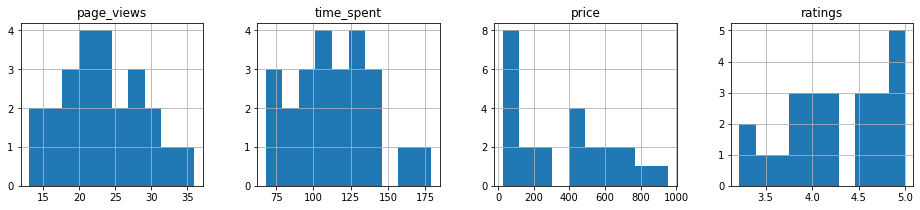

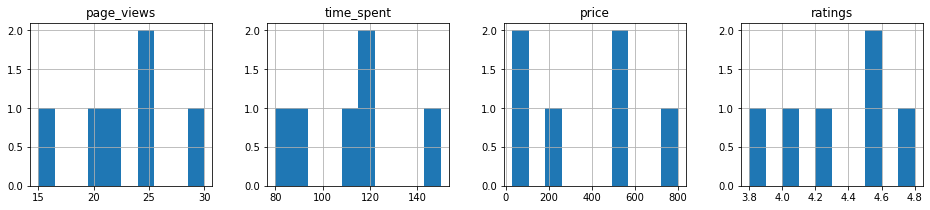

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
for i, col in enumerate(num_cols):
  data_synthetic[[col]].hist(ax=axes[i])
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
for i, col in enumerate(num_cols):
  merged_df[[col]].hist(ax=axes[i])
plt.show()

# Modelling

## with Original Data

In [23]:
# TO DO: Create pipeline to standardize data
scaler = StandardScaler() 

# user features
user_features = interaction.set_index("customer_id")
scaler.fit(user_features)
scaled_user_features = pd.DataFrame(scaler.transform(user_features), columns=user_features.columns, index=user_features.index)
print("scaled_user_features:")
display(scaled_user_features)

# bought items as binary features
data = merged_df.copy()
bought_items = data.pivot_table(index="customer_id", columns="product_id", values="category", aggfunc="count").fillna(0)
print("bought_items:")
display(bought_items)

# modelling
k=3
user_idx = {key:val for key,val in enumerate(user_features.index)}
model = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
model.fit(scaled_user_features, bought_items.iloc[:, 0]) 

def get_recommendation_simple(uid: int, k: int = 3) -> tuple[list[int], list[int]]:
  """
  Generates simple recommendations based on collaborative filtering.

  Args:
    uid (int): The user ID for whom to generate recommendations.
    k (int, optional): The number of recommendations to return. Defaults to 3.

  Returns:
    tuple[list[int], list[int]]: A tuple containing two lists:
        - The list of top k most similar user IDs.
        - The list of k recommended item IDs.
  """

  # Prepare input: extract scaled user features for the given user
  input_recsys = scaled_user_features.loc[uid].values

  # Find similar users based on the user features using k-nearest neighbors
  similar_users = model.kneighbors([input_recsys], n_neighbors=k+1, return_distance=False)[0]

  # Recommend items based on frequently bought items by similar users
  rec_items = []
  for idx in similar_users[1:]:  # Exclude the first similar user (the user themself)
    # Find items bought by the similar user
    tmp_item = bought_items.iloc[[idx]].sum(axis=0).sort_values(ascending=False)
    # Filter out items not bought by the user and keep top k recommendations
    tmp_item = list(tmp_item[tmp_item > 0].index)[:k]
    rec_items += tmp_item

  # Remove duplicates and keep top k recommendations
  recommend_items = list(OrderedDict.fromkeys(rec_items))[:k]

  # Map back to real user IDs
  similar_users = [user_idx[i] for i in similar_users]

  return similar_users, recommend_items

# testing
print("merged_df:")
display(merged_df)

print("test recommendation:")
for user_id in range(1,6):
  input_recsys = interaction.set_index("customer_id").loc[user_id].values
  print(user_id, ":", get_recommendation_simple(user_id))

scaled_user_features:


,page_views,time_spent
customer_id,,
1,0.519584,0.408248
2,-0.479616,-0.816497
3,1.518785,1.632993
4,-1.478817,-1.224745
5,-0.079936,0.000000


bought_items:


product_id,101,102,103,104,105
customer_id,,,,,
1,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,0.0


merged_df:


,customer_id,page_views,time_spent,product_id,purchase_date,category,price,ratings
0,4,15,80,104,2023-01-04,Beauty,30,4.0
1,2,20,90,102,2023-01-02,Clothing,50,3.8
2,5,22,110,101,2023-01-05,Electronics,500,4.5
3,1,25,120,101,2023-01-01,Electronics,500,4.5
4,1,25,120,105,2023-01-05,Electronics,800,4.8
5,3,30,150,103,2023-01-03,Home & Kitchen,200,4.2


test recommendation:
1 : ([1, 5, 2, 3], [101, 102, 103])
2 : ([2, 5, 4, 1], [101, 104, 105])
3 : ([3, 1, 5, 2], [101, 105, 102])
4 : ([4, 2, 5, 1], [102, 101, 105])
5 : ([5, 1, 2, 4], [101, 105, 102])


## with Synthetic Data

In [24]:
# TO DO: Create pipeline to standardize data
scaler = StandardScaler() 

# user features
train_data = pd.concat([merged_df, data_synthetic])
train_data.reset_index(drop=True, inplace=True)
new_interaction = train_data.copy()
user_features = new_interaction.groupby(["customer_id"]).agg("mean")[["page_views", "time_spent"]]

# standardize data
scaler.fit(user_features)
scaled_user_features = pd.DataFrame(scaler.transform(user_features), columns=user_features.columns, index=user_features.index)
print("scaled_user_features (train data):")
display(scaled_user_features)

# bought items as binary features
bought_items = train_data.pivot_table(index="customer_id", columns="product_id", values="category", aggfunc="count").fillna(0)
print("bought_items (train data):")
display(bought_items)

# modelling
user_idx = {key:val for key,val in enumerate(user_features.index)}
item_idx = train_data[["product_id","category"]].set_index("product_id").to_dict()["category"]
k=5
model = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
model.fit(scaled_user_features, bought_items.iloc[:, 0]) 

def get_recommendation(
        df: pd.DataFrame, 
        user_features: pd.DataFrame,
        bought_items: pd.DataFrame,
        model: sklearn.neighbors._classification.KNeighborsClassifier,
        user_idx: dict,  
        uid: int, 
        item_idx: dict, 
        n: int = 5, 
        k: int = 7
    ) -> tuple[list[int], list[int]]:
    """
    Recommends items to a user based on collaborative filtering.

    Args:
        df (pd.DataFrame): Base Data
        user_features (pd.DataFrame): user features that are `page_views` and `time_spent`
        bought_items (pd.DataFrame): historical data on product purchases by users
        model (sklearn.neighbors._classification.KNeighborsClassifier): 
        user_idx (dict): user index to look up
        uid (int): The user ID for whom to generate recommendations.
        item_idx (dict): item index to look up
        n (int, optional): The number of recommendations to return. Defaults to 5.
        k (int, optional): The number of nearest neighbors. Defaults to 8.

    Returns:
        tuple[list[int], list[int]]: A tuple containing two lists:
            - The list of top k most similar user IDs.
            - The list of k recommended item IDs.

    Raises:
        ValueError: If the user ID is not found in the user features data.
    """

    if uid not in user_features.index:
        raise ValueError(f"User with ID {uid} not found in user features data.")

    # Prepare input: extract scaled user features for the given user
    input_recsys = user_features.loc[uid].values

    # Find similar users based on the user features using k-nearest neighbors
    similar_users = model.kneighbors([input_recsys], n_neighbors=k+1, return_distance=False)[0]

    # Recommend items based on frequently bought items by similar users
    recommend_items = []
    for idx in similar_users[1:]:
        # Find items bought by the similar user (excluding the user themself)
        tmp_item = bought_items.iloc[[idx]].sum(axis=0).sort_values(ascending=False)
        # Filter out items not bought by the user and keep only the top k recommendations
        tmp_item = list(tmp_item[tmp_item > 0].index)#[:n]
        recommend_items += tmp_item
    
    # remove already bought item
    ## Sample case: customer id 5 already bought item_id 101
    already_bought = df.loc[df['customer_id'] == uid, 'product_id'].tolist()  # Get already bought items directly
    recommend_items = [item for item in recommend_items if item not in already_bought]  # Filter in a single line

    # Use OrderedDict to remove duplicates and keep the top k recommendations
    if n <= len(recommend_items):
        recommend_items = list(OrderedDict.fromkeys(recommend_items))[:n]
    
    # get user ID
    similar_users = [user_idx[i] for i in similar_users]
    recommend_categories = [item_idx[i] for i in recommend_items]
    return similar_users, recommend_items, recommend_categories

# checking
print("train_data:")
display(train_data)

print("recommendation with train data:")
for user_id in user_features.index: 
  print(user_id, ":", get_recommendation(train_data, scaled_user_features, bought_items, model, user_idx, user_id, item_idx))


scaled_user_features (train data):


,page_views,time_spent
customer_id,,
1,0.355404,0.278511
2,-0.548694,-0.838100
3,1.259502,1.395122
4,-1.452792,-1.210304
5,-0.187055,-0.093693
17,-0.367874,-0.317015
18,1.259502,1.134580
19,0.174584,0.017968
20,0.897863,1.097359


bought_items (train data):


product_id,101,102,103,104,105,426,427,428,429,430,...,440,441,442,443,444,445,446,447,448,449
customer_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


train_data:


,customer_id,page_views,time_spent,product_id,purchase_date,category,price,ratings
0,4,15,80,104,2023-01-04,Beauty,30,4.00
1,2,20,90,102,2023-01-02,Clothing,50,3.80
2,5,22,110,101,2023-01-05,Electronics,500,4.50
3,1,25,120,101,2023-01-01,Electronics,500,4.50
4,1,25,120,105,2023-01-05,Electronics,800,4.80
5,3,30,150,103,2023-01-03,Home & Kitchen,200,4.20
6,25,13,68,443,2023-01-04,Beauty,25,3.39
7,40,17,76,429,2023-01-02,Clothing,42,3.22
8,28,19,93,444,2023-01-04,Electronics,424,3.82
9,34,21,102,438,2023-01-01,Electronics,424,3.82


recommendation with train data:
1 : ([1, 30, 32, 19, 37, 24, 26, 23], [439, 449, 433, 437, 436], ['Home & Kitchen', 'Electronics', 'Electronics', 'Electronics', 'Electronics'])
2 : ([2, 28, 27, 39, 21, 34, 31, 17], [444, 431, 445, 446, 438], ['Electronics', 'Clothing', 'Clothing', 'Beauty', 'Electronics'])
3 : ([3, 33, 18, 20, 38, 23, 26, 24], [426, 427, 428, 432, 440], ['Electronics', 'Electronics', 'Home & Kitchen', 'Home & Kitchen', 'Electronics'])
4 : ([4, 36, 29, 40, 25, 27, 21, 28], [448, 434, 429, 443, 431], ['Beauty', 'Beauty', 'Clothing', 'Beauty', 'Clothing'])
5 : ([5, 17, 37, 31, 34, 32, 22, 19], [435, 437, 442, 438, 449], ['Electronics', 'Electronics', 'Electronics', 'Electronics', 'Electronics'])
17 : ([17, 31, 34, 5, 39, 28, 2, 22], [442, 438, 101, 445, 444], ['Electronics', 'Electronics', 'Electronics', 'Clothing', 'Electronics'])
18 : ([33, 18, 3, 20, 38, 23, 26, 24], [103, 428, 432, 440, 441], ['Home & Kitchen', 'Home & Kitchen', 'Home & Kitchen', 'Electronics', 'Elect

# Model Evaluation

In [25]:
# testing
y_test = test_set[["customer_id","category"]]
y_test.set_index("customer_id", inplace=True)

x_test = test_set.groupby(["customer_id"]).agg("mean")[["page_views", "time_spent"]]
test_data = x_test.merge(y_test, left_index=True, right_index=True)

display(test_set)
display(test_data)

test_user_idx = {key:val for key,val in enumerate(x_test.index)}

# prediction 
prediction = {}

# baseline comparation
prediction_random = {}
prediction_top_rating = {}

for user_id in test_data.index: 
  
  
  sim_user, prod_id, cat_item = get_recommendation(train_data, scaled_user_features, bought_items, model, user_idx, user_id, item_idx)
  print(user_id, ":", cat_item)
  
  prediction[user_id] = {
    "ground_truth": [y_test.loc[user_id].values[0]],
    "recommendation": cat_item
  }

  prediction_random[user_id] = {
    "ground_truth": [y_test.loc[user_id].values[0]],
    "recommendation": random.sample(list(train_data.category.values), 5)
  }

  prediction_top_rating[user_id] = {
    "ground_truth": [y_test.loc[user_id].values[0]],
    "recommendation": train_data.sort_values("ratings",ascending=False).category.tolist()[:5]
  }

,customer_id,page_views,time_spent,product_id,purchase_date,category,price,ratings
12,36,14,76,448,2023-01-04,Beauty,28,3.78
13,27,19,85,431,2023-01-02,Clothing,47,3.59
14,17,21,104,435,2023-01-05,Electronics,472,4.25
20,24,26,131,436,2023-01-05,Electronics,597,5.00
4,31,21,102,442,2023-01-04,Electronics,679,4.07
5,30,25,127,439,2023-01-03,Home & Kitchen,170,3.56


,page_views,time_spent,category
customer_id,,,
17,21.0,104.0,Electronics
24,26.0,131.0,Electronics
27,19.0,85.0,Clothing
30,25.0,127.0,Home & Kitchen
31,21.0,102.0,Electronics
36,14.0,76.0,Beauty


17 : ['Electronics', 'Electronics', 'Electronics', 'Clothing', 'Electronics']
24 : ['Electronics', 'Electronics', 'Home & Kitchen', 'Electronics', 'Electronics']
27 : ['Clothing', 'Electronics', 'Beauty', 'Clothing', 'Beauty']
30 : ['Electronics', 'Electronics', 'Electronics', 'Electronics', 'Electronics']
31 : ['Electronics', 'Electronics', 'Clothing', 'Electronics', 'Clothing']
36 : ['Beauty', 'Beauty', 'Beauty', 'Clothing', 'Clothing']


{17: {'ground_truth': ['Electronics'],
      'recommendation': ['Electronics',
                         'Electronics',
                         'Electronics',
                         'Clothing',
                         'Electronics']},
 24: {'ground_truth': ['Electronics'],
      'recommendation': ['Electronics',
                         'Electronics',
                         'Home & Kitchen',
                         'Electronics',
                         'Electronics']},
 27: {'ground_truth': ['Clothing'],
      'recommendation': ['Clothing',
                         'Electronics',
                         'Beauty',
                         'Clothing',
                         'Beauty']},
 30: {'ground_truth': ['Home & Kitchen'],
      'recommendation': ['Electronics',
                         'Electronics',
                         'Electronics',
                         'Electronics',
                         'Electronics']},
 31: {'ground_truth': ['Electronics'],
      'recomm

,KNN,Random,Top_Rating
MRR,0.8333,0.5750,0.4167
MAP,0.5333,0.2667,0.4333


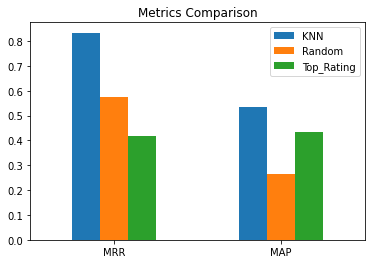

In [18]:
def calculate_metrics(data:dict, k:int = 5):
  """
  Calculates Mean Reciprocal Rank (MRR) and Mean Average Precision (MAP) for recommendation data.

  Args:
    data: A dictionary where keys are user IDs and values are dictionaries containing
          'ground_truth' (list of relevant items) and 'recommendation' (list of predicted items).

  Returns:
    A dictionary containing calculated MRR and MAP values.
  """
  rr = 0.0
  ap = 0.0
  for user_id, user_data in data.items():
    ground_truth = user_data['ground_truth']
    recommendation = user_data['recommendation']

    # Calculate RR
    for i, item in enumerate(recommendation):
      if item in ground_truth:
        rr += 1 / (i + 1)
        break

    # Calculate AP
    relevant_at_k = recommendation[:k].count(ground_truth[0])
    precision_at_k = relevant_at_k / k
    ap += precision_at_k / len(ground_truth)

  # Calculate MRR and MAP
  mrr = rr / len(data)
  map = ap / len(data)

  return {'MRR': mrr, 'MAP': map}


metrics = calculate_metrics(prediction)
metrics_pred_random = calculate_metrics(prediction_random)
metrics_pred_top_rating = calculate_metrics(prediction_top_rating)

metrics_df = pd.DataFrame(
  {
    "KNN": metrics,
    "Random": metrics_pred_random,
    "Top_Rating": metrics_pred_top_rating,
    }
)

pprint(prediction)
metrics_df.plot(kind="bar", rot=0)
plt.title("Metrics Comparison")
metrics_df.round(4)


# Saving Objects

In [19]:
# choose object to save
pipeline_objects = {
  "model": model,
  "encoder_categories": le_cat,
  "database": train_data,
  "scaled_user_features": scaled_user_features,
  "bought_items": bought_items,
  # "encoder_purchase_date": le_pd,
  "model": model,
  "user_idx": user_idx, 
  "item_idx":item_idx
}

# saving
with open("../pipeline_objects.pkl", "wb") as f:
  pickle.dump(pipeline_objects, f)

# test load
with open("../pipeline_objects.pkl", "rb") as f:
  loaded_dict = pickle.load(f)

print("Loaded pipeline_objects:", loaded_dict)

Loaded pipeline_objects: {'model': KNeighborsClassifier(metric='euclidean'), 'encoder_categories': LabelEncoder(), 'database':     customer_id  page_views  time_spent  product_id purchase_date  \
0             4          15          80         104    2023-01-04   
1             2          20          90         102    2023-01-02   
2             5          22         110         101    2023-01-05   
3             1          25         120         101    2023-01-01   
4             1          25         120         105    2023-01-05   
5             3          30         150         103    2023-01-03   
6            25          13          68         443    2023-01-04   
7            40          17          76         429    2023-01-02   
8            28          19          93         444    2023-01-04   
9            34          21         102         438    2023-01-01   
10           31          21         102         442    2023-01-04   
11           30          25         127      